In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split
import torch.nn as nn
import torchvision
import torch.optim as optim


import numpy as np
import time
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import top_k_accuracy_score
from main import Xception, print_test_details, train_transform, test_transform
from main import print_test_details, ResNet, BasicBlock, BottleNeck, train_transform, test_transform #custom function in main.py
import cv2


import json, os


In [2]:
# HYPERPARAMETERS

train_size = 0.8
test_size=0.2
cuda = 'cuda'
cpu = 'cpu' 
device = cuda if torch.cuda.is_available() else cpu


In [3]:

class myDataset(torch.utils.data.Dataset):

    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x, y = self.data[index]
        if self.transform:
            x = self.transform(x)
        return x, y
   


In [4]:

full_dataset = torchvision.datasets.ImageFolder(
    root='./dataset',
    transform=None
)

train, test = random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(0))


test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
])


train_dataset = myDataset(train, transform=train_transform)
test_dataset = myDataset(test, transform=test_transform)
# 
batch_size=32
# 
train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True, 
)




test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=False   
)   

In [5]:
mapping = {}

for key, value in full_dataset.class_to_idx.items():
    mapping[value] = key

In [6]:

resnet = ResNet(
    block=BottleNeck,
    layers=[2, 2, 2, 2]
)

resnet.load_state_dict(torch.load("resnet28_selfimplementation_kaggle.pth"))
resnet.to(device)
resnet.eval()


xception = Xception(5)
xception.load_state_dict(torch.load("xception_middle5_5.9M.pth"))
xception.to(device)
xception.eval()

print()



In [7]:
xception

Xception(
  (block1_conv1): BN_DepthwiseSeparableConv2D(
    (depthwise_conv): Conv2d(3, 3, kernel_size=(3, 3), stride=(2, 2), groups=3, bias=False)
    (pointwise_conv): Conv2d(3, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (block1_conv2): BN_DepthwiseSeparableConv2D(
    (depthwise_conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), groups=32, bias=False)
    (pointwise_conv): Conv2d(32, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (residual1): BNConv2D(
    (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (residual2): BNConv2D(
    (conv): Conv2d(128, 256, kernel_size=(1, 1), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine

### Function for generating the heatmap

In [8]:
def process_image(path, output_size=224, random_crop:bool=False, normalize=True):

    img = cv2.imread(path, cv2.IMREAD_COLOR)


    img = transforms.ToTensor()(img)

    if random_crop:
        img = transforms.Resize(output_size+32)(img)
        img = transforms.RandomCrop(output_size)
    else:
        img = transforms.Resize((output_size, output_size))(img)

    
    if normalize:
        img = transforms.Normalize([0.5]*3, [0.5]*3)(img)

    return img.to(device)
    
def get_conv_layer(model, conv_layer_name):
    for name, layer in model.named_modules():
        if name == conv_layer_name:
            return layer
    raise ValueError(f"Layer '{conv_layer_name}' not found in the model.")


In [9]:
def compute_gradcam(model, image_tensor:torch.Tensor, class_index, layer_name):

    assert image_tensor.shape[0] == 3 or image_tensor.shape[1]==3, "Number of channels must 3, if either batched or unbatched input"

    assert image_tensor.ndim in (4, 3), "Excepted 4D or 3D input, got {}".format(image_tensor.ndim)

    if image_tensor.ndim == 3:
        image_tensor = torch.unsqueeze(image_tensor, 0)

    assert image_tensor.shape[0]==1, f"Expected batch_size to be 1, got {image_tensor[0]}"

    
    conv_layer:nn.Module = get_conv_layer(model, layer_name)

    activations:torch.Tensor = None
    def forward_hook(module, input, output):
        nonlocal activations
        activations = output
        activations.retain_grad()

    hook = conv_layer.register_forward_hook(forward_hook)

    


    image_tensor.requires_grad_(True)
    predictions = model(image_tensor)
    class_loss = predictions[:, class_index]

    model.zero_grad()
    model.eval()
    class_loss.backward()

    grads = activations.grad
    pooled_grads = torch.mean(grads, axis=(0, 2, 3))


    hook.remove()

    activations = activations[0] #take only the first image, as batch_size=1
    for i in range(pooled_grads.shape[0]):
        activations[i] *= pooled_grads[i]
    
    heatmap = torch.mean(activations, axis=0)
    heatmap /= torch.max(heatmap)
    heatmap = torch.maximum(heatmap, torch.zeros_like(heatmap))


    
    heatmap = heatmap.detach().cpu().numpy()

    

    

    return heatmap

def overlay_heatmap(img_path, heatmap, alpha=0.7):

    img = cv2.imread(img_path, cv2.IMREAD_COLOR)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_img = cv2.addWeighted(img, alpha, heatmap, 1 - alpha, 0)
    return superimposed_img


def compute_final_image_from_imgtensor(model:nn.Module, image_tensor:torch.Tensor, class_label:int, conv_layer:str, alpha=0.7):

    heatmap = compute_gradcam(model, image_tensor, class_label, conv_layer)
    
    img = torch.permute(image_tensor, (1, 2, 0)).detach().cpu().numpy()

    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = (255 * heatmap).astype(np.int8)

    print(heatmap.tolist())
    print(heatmap.shape)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    superimposed_image = cv2.addWeighted(img, alpha, heatmap, 1-alpha, 0)
    return superimposed_image


#### Example of how to get heatmap from an image path

In [33]:
bat_path = "./dataset/213.teddy-bear/213_0008.jpg"

img_tensor = process_image(bat_path)

class_index=7

heatmap = compute_gradcam(xception, img_tensor, class_index, "exitblock1_conv2" )
output_img = overlay_heatmap(bat_path, heatmap)
cv2.imwrite("heatmap.jpg", output_img) 

True

In [34]:
correctly_classified_xception = correctly_classified_resnet = ['./dataset\\250.zebra\\250_0029.jpg',
 './dataset\\230.trilobite-101\\230_0011.jpg',
 './dataset\\087.goldfish\\087_0058.jpg',
 ]


incorrectly_classified_resnet = incorrectly_classified_xception = ['./dataset\\251.airplanes-101\\251_0399.jpg',
 './dataset\\193.soccer-ball\\193_0049.jpg',
 './dataset\\145.motorbikes-101\\145_0094.jpg']


correctly_classified_resnet_images = []
incorrectly_classified_resnet_images = []
correctly_classified_xception_images = []
incorrectly_classified_xception_images = []


for i in correctly_classified_xception:
    img_tensor = process_image(i, 299)
    class_label = int(i.split('\\')[-1].split('_')[0])-1
    heatmap = compute_gradcam(xception, img_tensor, class_label, "exitblock1_conv2" )
    output_img = overlay_heatmap(i, heatmap)
    correctly_classified_xception_images.append(output_img)


for i in incorrectly_classified_xception:
    img_tensor = process_image(i, 299)
    class_label = int(i.split('\\')[-1].split('_')[0])-1
    heatmap = compute_gradcam(xception, img_tensor, class_label, "exitblock1_conv2" )
    output_img = overlay_heatmap(i, heatmap)
    incorrectly_classified_xception_images.append(output_img)



for i in correctly_classified_resnet:
    img_tensor = process_image(i)
    class_label = int(i.split('\\')[-1].split('_')[0])-1
    heatmap = compute_gradcam(resnet, img_tensor, class_label, "layer4" )
    output_img = overlay_heatmap(i, heatmap)
    correctly_classified_resnet_images.append(output_img)


for i in incorrectly_classified_resnet:
    img_tensor = process_image(i)
    class_label = int(i.split('\\')[-1].split('_')[0])-1
    heatmap = compute_gradcam(resnet, img_tensor, class_label, "layer4" )
    output_img = overlay_heatmap(i, heatmap)
    incorrectly_classified_resnet_images.append(output_img)



In [ ]:
figure, ax = plt.subplots(2, 3, figsize=(20, 10))



for i, image in enumerate(correctly_classified_xception_images):
    ax[0, i].imshow(image)
for i, image in enumerate(correctly_classified_resnet_images):
    ax[1, i].imshow(image)
# for i, image in enumerate(incorrectly_classified_xception_images):
#     ax[2, i].imshow(image)
# for i, image in enumerate(incorrectly_classified_resnet_images):
#     ax[3, i].imshow(image)

for a in ax.flat:
    a.axis('off')

In [ ]:
images = []
for root, _, files in os.walk("./dataset"):
    for file in files:
        if file.endswith(".jpg"):
            images.append(os.path.join(root, file))


images = np.array(images)
np.random.seed(0)
np.random.shuffle(images)

correctly_classified_resnet = []
incorrectly_classified_resnet = []

correctly_classified_xception = []
incorrectly_classified_xception = []


for image_path in images:

    class_label = int(images[0].split('\\')[-1].split('_')[0])-1

    image_tensor_resnet = torch.unsqueeze(process_image(image_path), 0)

    any = False
    output = resnet(image_tensor_resnet)

    if (torch.argmax(output, -1).item()==class_label):# and len(correctly_classified_resnet) < 5:
        any = True
        correctly_classified_resnet.append(image_path)

    if (torch.argmax(output, -1).item()!=class_label):# and len(incorrectly_classified_resnet) < 5:
        any = True
        incorrectly_classified_resnet.append(image_path)
    
    image_tensor_xception = process_image(image_path, 299)

    if (torch.argmax(output, -1).item()==class_label):# and len(correctly_classified_xception) < 5:
        any = True
        correctly_classified_xception.append(image_path)

    if (torch.argmax(output, -1).item()!=class_label):# and len(incorrectly_classified_xception) < 5:
        any = True
        incorrectly_classified_xception.append(image_path)
    
    



    

In [10]:
import timm

model:timm.models.Xception = timm.create_model("xception", pretrained=True, num_classes=256, drop_rate=0.3)

model.load_state_dict(torch.load("xception20M_fine_tuned.pth"))

for p in model.parameters():
    p.requires_grad=False


for p in model.fc.parameters():
    p.requires_grad = True
for p in model.conv4.parameters():
    p.requires_grad=True
for p in model.bn4.parameters():
    p.requires_grad = True


model.to(device)




criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)

sum([p.numel() for p in model.parameters() if p.requires_grad])

C:\Users\SUDARSHAN\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\timm\models\_factory.py:126: UserWarning: Mapping deprecated model name xception to current legacy_xception.
  model = create_fn(


3688192

In [ ]:
for epoch in range(2):

    start = time.time()
    total_training_loss = 0
    total_training_samples = 0
    total_training_correct_classfied = 0

    iteration_start =time.time()
    model.train()

    for iteration, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        output_predictions = model(images)

        loss_value = criterion(output_predictions, labels)

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()

        

        
        total_training_loss += loss_value.item()*labels.shape[0]
        total_training_samples += labels.shape[0]
        _, predicted = torch.max(output_predictions, dim=1)
        total_training_correct_classfied += (labels == predicted).sum().item()

        if iteration%250==0:
            print(f"iteration {iteration+1} done. time taken={time.time()-iteration_start}")
            iteration_start = time.time()

    print_text = f"epoch: {epoch+1}, train loss: {total_training_loss/ total_training_samples}, train accuracy: {total_training_correct_classfied/total_training_samples}, time taken: {time.time()-start}"
    

    print(f"epoch: {epoch+1}, train loss: {total_training_loss/ total_training_samples}, train accuracy: {total_training_correct_classfied/total_training_samples}, time taken: {time.time()-start}")

    # if (epoch-1)%3==0:
    #     print_test_details(model, criterion, test_loader)   
    print()





In [11]:
images_i_care_about_correct = []
images_i_care_about_incorrect = []

for image, label in iter(test_loader):

    image, label = image.to(device), label.to(device)
    
    output = xception(transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))(image))


    if torch.argmax(output).item()==label.item() :
        images_i_care_about_correct.append((torch.squeeze(image), label, torch.argmax(output).item()))
    else:
        images_i_care_about_incorrect.append((torch.squeeze(image), label, torch.argmax(output).item()))


        
    if (len(images_i_care_about_correct)>20 and len(images_i_care_about_incorrect)>10):
        break


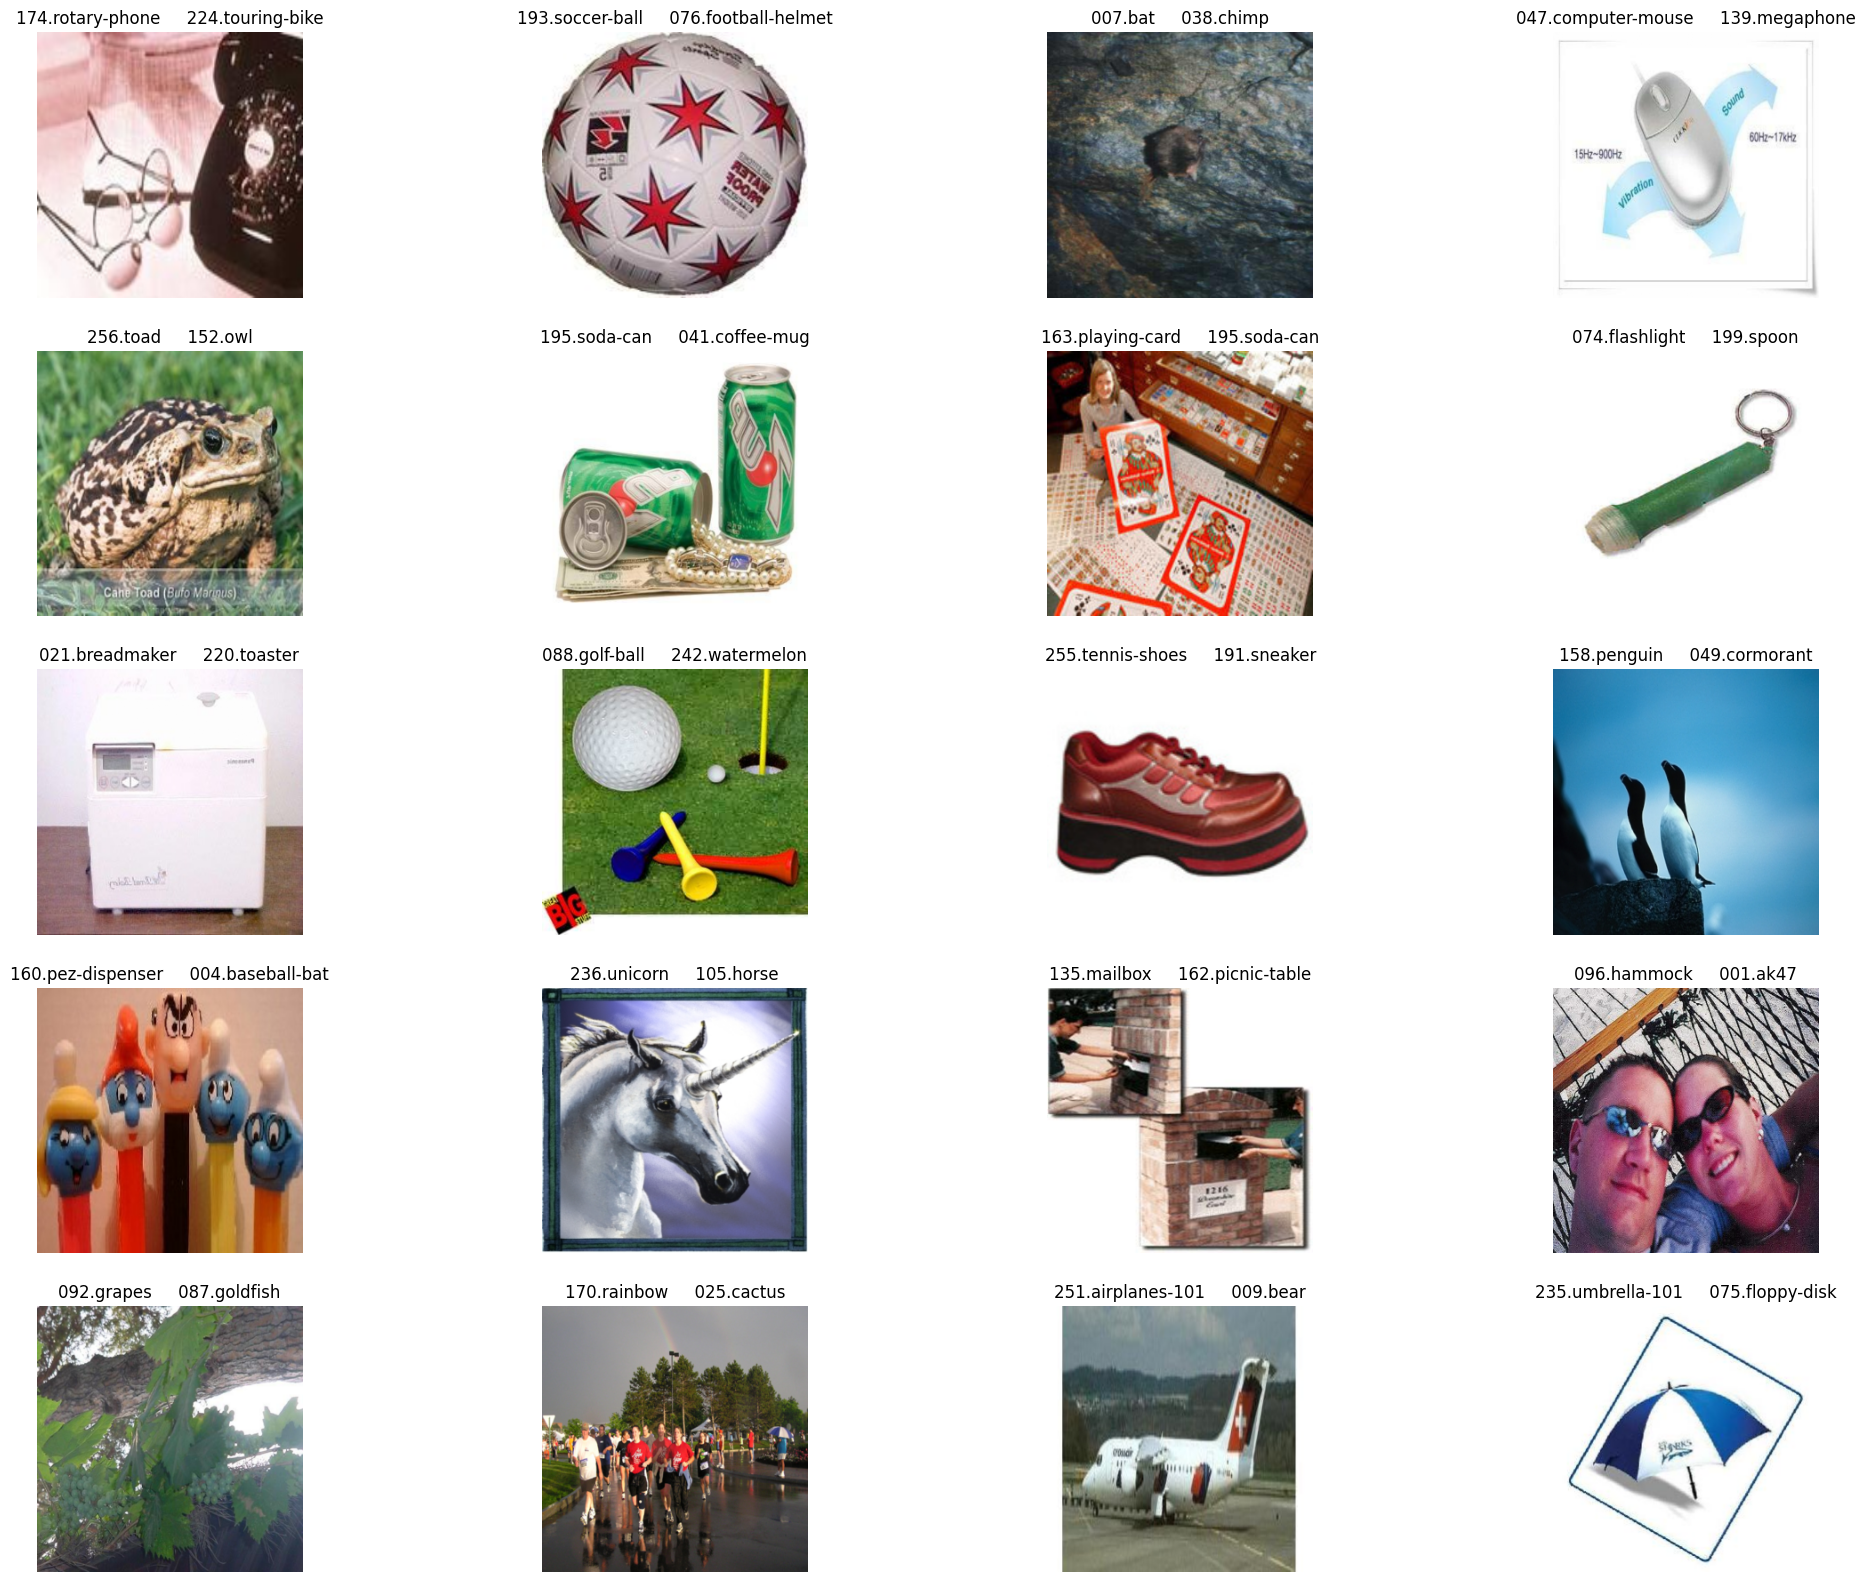

In [12]:
figure, ax = plt.subplots(5, 4, figsize=(25, 20))



for i, a in enumerate(ax.flat):

    image = torch.permute(images_i_care_about_incorrect[i][0], [1, 2, 0]).detach().cpu().numpy()
    label_index = images_i_care_about_incorrect[i][1].detach().cpu().item()
    class_name = mapping[label_index]
    predicted_class_name = mapping[images_i_care_about_incorrect[i][2]]


    a.imshow(image)
    a.set_title(f"{class_name}     {predicted_class_name}")
    a.axis('off')

    

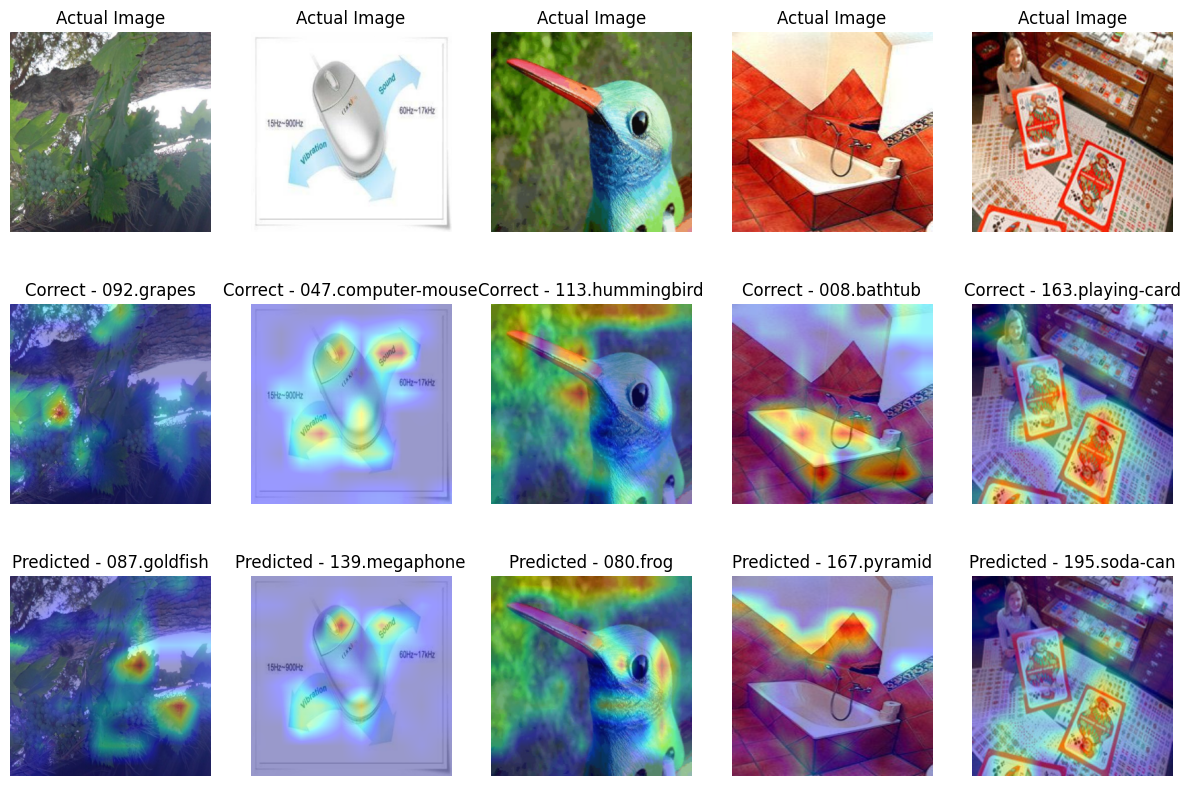

In [ ]:
import random

random.seed(428)

#58 for xception
images = random.sample(images_i_care_about_incorrect, k=5)
images = images_i_care_about_incorrect


plotted = 0

fi, ax = plt.subplots(3, 5, figsize=(15, 10))

for i, (image, correct_label, incorrect_label) in enumerate(images):
    
    H, W = image.shape[1], image.shape[2]

    # image = transforms.Resize((224, 224))(image)

    image_n = torch.permute(image, (1, 2, 0)).detach().cpu().numpy()
    correct_label = correct_label.detach().cpu().item()

    image = transforms.Normalize([0.5]*3, [0.5]*3)(image)
    
    correct_name = mapping[correct_label]
    predicted_name = mapping[incorrect_label]

    ax[0, i].imshow(image_n)
    ax[0, i].set_title("Actual Image")


    heatmap = compute_gradcam(resnet, image, correct_label, 'layer4')
    heatmap = cv2.resize(heatmap, (H, W))
    
    ax[1, i].imshow(image_n)
    ax[1, i].imshow(heatmap, cmap='jet', alpha=0.4)
    ax[1, i].set_title(f"Correct - {correct_name}")

    heatmap = compute_gradcam(resnet, image, incorrect_label, 'layer4')
    heatmap = cv2.resize(heatmap, (H, W))
    ax[2, i].imshow(image_n)
    ax[2, i].imshow(heatmap, cmap='jet', alpha=0.4)
    ax[2, i].set_title(f"Predicted - {predicted_name}")


for a in ax.flat:
    a.axis('off')
    
# plt.close(fi)

In [152]:
torch.save(model.state_dict(), "xception20M_fine_tuned.pth")